In [ ]:
! pip install pydicom

In [ ]:
import os
import torch
import random
import pydicom
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import resnet50
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
if torch.cuda.is_available():
    print("CUDA is available. You can use GPU acceleration.")
else:
    print("CUDA is not available. GPU acceleration is not supported.")

CUDA is available. You can use GPU acceleration.


In [ ]:
# Check the number of available CUDA devices
num_cuda_devices = torch.cuda.device_count()
print("Number of CUDA devices available:", num_cuda_devices)

Number of CUDA devices available: 1


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # MetaData CSV File
# metadata_file = '/content/drive/MyDrive/metadata.csv'
# metadata_data = pd.read_csv(metadata_file)

In [ ]:
# metadata_data.keys()

In [ ]:
# metadata_data.head()

In [ ]:
# files_path = '/content/drive/MyDrive/BCS-DBT-file-paths-test-v2.csv'
# files_path_data = pd.read_csv(files_path).drop(['View'], axis=1)

In [ ]:
# files_path_data.keys()

In [ ]:
# files_path_data.head()

In [ ]:
# files_path_data.shape

In [ ]:
# labels_path = '/content/drive/MyDrive/BCS-DBT-labels-test-PHASE-2.csv'
# labels_path_data = pd.read_csv(labels_path)

In [ ]:
# labels_path_data.keys()

In [ ]:
# labels_path_data.head()

In [ ]:
# images_path = files_path_data['descriptive_path']
# views_per_path = labels_path_data['View']
# labels = labels_path_data[['Normal', 'Actionable', 'Benign','Cancer']]

In [ ]:
# labels.shape

In [ ]:
# print('Th Available View Types: ', views_per_path.unique())

### **Pre-Process the Data & Get Custom Dataset**

In [ ]:
# # Concatenate 'PatientID' and 'StudyUID' columns into a new column
# files_path_data['Combined_ID'] = files_path_data['PatientID'] + '_' + files_path_data['StudyUID']
# files_path_data = files_path_data.drop(['PatientID', 'StudyUID'], axis=1)


# labels_path_data['Combined_ID'] = labels_path_data['PatientID'] + '_' + labels_path_data['StudyUID']
# labels_path_data = labels_path_data.drop(['PatientID', 'StudyUID'], axis=1)

In [ ]:
# files_path_data.head()

In [ ]:
# labels_path_data.head()

In [ ]:
# # Merge the Labels & Images Path DataFrames based on the 'StudyUID' column
# merged_df = pd.merge(files_path_data, labels_path_data, on='Combined_ID', how='inner')
# # Drop the 'classic_path' column if it's not needed
# merged_df = merged_df.drop(['classic_path'], axis=1)

In [ ]:
# merged_df.head()

In [ ]:
# merged_df.shape

In [ ]:
# # Desired total number of images
# total_images = 2900
# # Group the DataFrame by the combination of all four class labels
# groups = merged_df.groupby(['Normal', 'Actionable', 'Benign', 'Cancer'])

# # Create an empty list to store sampled subsets
# subsets = []

# # Sample a subset of images from each group
# for name, group in groups:
#     sampled_subset = group.sample(min(total_images // len(groups), len(group)))
#     subsets.append(sampled_subset)


# # Concatenate the sampled subsets into a new DataFrame
# reduced_df = pd.concat(subsets)


# # Save the new DataFrame to a CSV file
# reduced_csv_file = '/content/drive/MyDrive/reduced_data.csv'
# reduced_df.to_csv(reduced_csv_file, index=True)

# print("Reduced CSV file created successfully.")

In [ ]:
# reduced_df = reduced_df.reset_index(drop=True)  # , inplace=True

In [ ]:
# reduced_df.head()

In [ ]:
# reduced_df.shape

### **Helper Classes & Functions**

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, view_type, image_data, labels, transform=None):
        self.view_type = view_type
        self.image_data = image_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        view_type = self.view_type[idx]
        image = self.image_data[idx]
        label = self.labels[idx]

        label = torch.tensor(label)
        view_type = torch.tensor(view_type)

        if self.transform:
            image = self.transform(image)

        return view_type, image, label

In [ ]:
def get_arrays():

    output_dir = '/content/drive/MyDrive/pixel arrays'
    images, views, labels = [], [], []

    # Iterate over saved .npy files
    for filename in os.listdir(output_dir):

        if filename.endswith('.npy'):
            # Load the pixel array from .npy file
            npy_path = os.path.join(output_dir, filename)
            pixel_array = np.resize(np.load(npy_path), (500, 500))

            # Append the Image Array , Label, and view type in the corresponding arrays
            images.append(pixel_array)
            labels.append(int(filename.split('_')[1]))
            views.append(int((filename.split('_')[2]).split('.')[0]))

            # Now you can use the pixel_array for further processing or analysis
            print("Pixel array shape:", pixel_array.shape)

    return np.array(images), np.array(labels), np.array(views) # Return the Image Array , Label, and view type arrays

In [ ]:
# Apply Preprocessing to the images, and divide to batches
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5)),
                              ])

In [ ]:
images, labels, views  = get_arrays()

Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel array shape: (500, 500)
Pixel arra

### **Dataset Visualization**

In [ ]:
dataset = CustomDataset(views, images, labels, transform=transform)

Normal / Class 0 : 723
Actionable / Class 1 : 725
Benign / Class 2 : 127
Cancer / Class 3 : 114


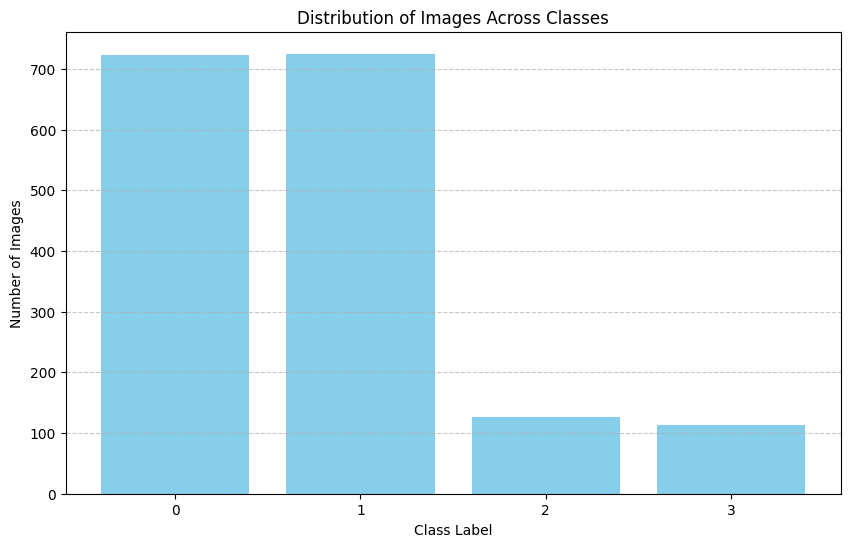

In [ ]:
# Count the occurrences of each class label
classes_dict = { 0: 'Normal',
                 1: 'Actionable',
                 2: 'Benign',
                 3: 'Cancer',
                }
unique_labels, counts = np.unique(labels, return_counts=True)

for class_count in range(4):
  print(f'{classes_dict[class_count]} / Class {class_count} : {counts[class_count]}')

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.xticks(unique_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **Remove Some Samples From Dominant Classes**

In [ ]:
# # Get indices of class 0 and class 1
# class_0_indices = np.where(labels == 0)[0]
# class_1_indices = np.where(labels == 1)[0]

# # Remove 200 images from class 0 and 200 images from class 1
# class_0_indices_to_remove = np.random.choice(class_0_indices, size=200, replace=False)
# class_1_indices_to_remove = np.random.choice(class_1_indices, size=200, replace=False)

# # Remove the selected indices from the dataset
# remaining_indices = np.setdiff1d(np.arange(len(dataset)), np.concatenate([class_0_indices_to_remove, class_1_indices_to_remove]))

# # Create a new dataset with the remaining indices
# views = np.array([views[i] for i in remaining_indices])
# images = np.array([images[i] for i in remaining_indices])
# labels = np.array([labels[i] for i in remaining_indices])

# dataset = CustomDataset(views, images, labels, transform=transform)

In [ ]:
# # Count the occurrences of each class label
# classes_dict = { 0: 'Normal',
#                  1: 'Actionable',
#                  2: 'Benign',
#                  3: 'Cancer',
#                 }
# unique_labels, counts = np.unique(labels, return_counts=True)

# for class_count in range(4):
#   print(f'{classes_dict[class_count]} / Class {class_count} : {counts[class_count]}')

# # Plot the distribution
# plt.figure(figsize=(10, 6))
# plt.bar(unique_labels, counts, color='skyblue')
# plt.xlabel('Class Label')
# plt.ylabel('Number of Images')
# plt.title('Distribution of Images Across Classes')
# plt.xticks(unique_labels)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

### **Augment The Minority Class**

In [ ]:
# # Define a list of transformations you want to apply randomly
# transform_list = [
#     transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
#     transforms.RandomVerticalFlip(p=0.5),    # Randomly flip the image vertically with a probability of 0.5
#     transforms.RandomRotation(degrees=(-15, 15)),  # Randomly rotate the image between -15 and 15 degrees
# ]


# images_temp , labels_temp, views_temp = images.copy(), labels.copy(), views.copy()

# for i in range(2):
#   for image, label, view in zip(images_temp, labels_temp, views_temp):
#     if (label==2) or (label==3):
#       # Randomly apply transformations from the list to the input with a probability of 0.5 each
#       random_transform = transforms.RandomApply(transform_list, p=0.5)
#       # Convert NumPy array to PIL image
#       pil_image = Image.fromarray(image.astype(np.uint8))
#       augmented_image = random_transform(pil_image)

#       # Append the augmented image and its corresponding label & view to the relative arrays
#       images = np.append(images, np.expand_dims(np.array(augmented_image), axis=0), axis=0)
#       labels = np.append(labels, label)
#       views = np.append(views, view)

In [ ]:
images.shape

(1689, 500, 500)

In [ ]:
dataset = CustomDataset(views, images, labels, transform=transform)

Normal / Class 0 : 723
Actionable / Class 1 : 725
Benign / Class 2 : 127
Cancer / Class 3 : 114


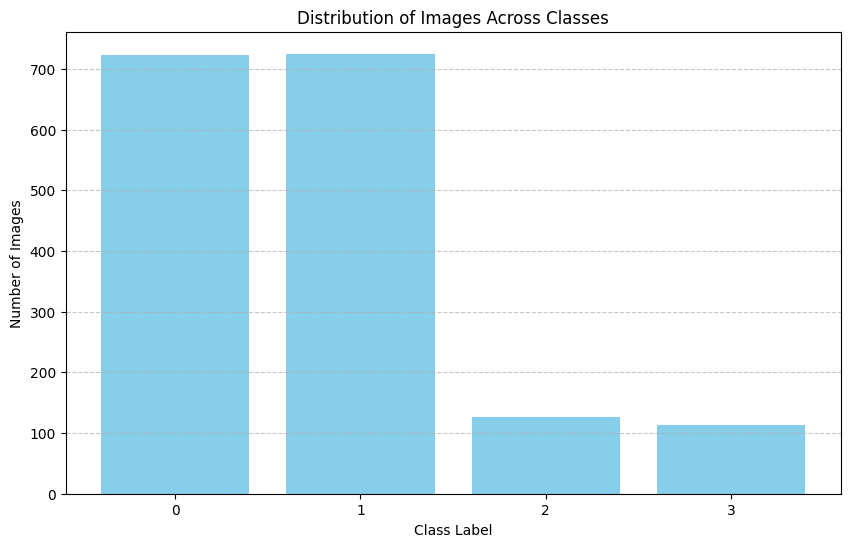

In [ ]:
# Count the occurrences of each class label
classes_dict = { 0: 'Normal',
                 1: 'Actionable',
                 2: 'Benign',
                 3: 'Cancer',
                }
unique_labels, counts = np.unique(labels, return_counts=True)

for class_count in range(4):
  print(f'{classes_dict[class_count]} / Class {class_count} : {counts[class_count]}')

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.xticks(unique_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **Divide Dataset to Training & Test data**

In [ ]:
from torch.utils.data import random_split

# Define the sizes of the train, validation, and test sets
train_size = int(0.8 * len(dataset))  # 80% of the data for training
val_size = int(0.1 * len(dataset))    # 10% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining data for testing

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Get the length of train & test data
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 1351
Test dataset size: 170
Validation dataset size: 168


### **Get Train & Test Dataloaders**

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### **Begin Training Phase**

#### **1. Define your Model Architecture**

In [ ]:
# Select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = resnet50(pretrained=True)
        # # Freeze all the parameters except the last fc layer
        # for name, param in self.resnet.named_parameters():
        #     if "fc" not in name:  # Exclude the last fully connected layer
        #         param.requires_grad = False
        # Modify the last layer
        num_inputs = self.resnet.fc.in_features
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # self.resnet.fc = nn.Linear(num_inputs, num_classes)
        self.resnet.fc = nn.Sequential(
                                          nn.Linear(num_inputs, 256),
                                          nn.ReLU(),
                                          nn.Dropout(0.5),
                                          nn.Linear(256, num_classes)
                                         )

    def forward(self, image, view_type):
        # Ensure that the input tensor has the correct dimensions
        if len(image.shape) == 3:
            # Add an additional dimension for the batch size
            image = image.unsqueeze(0)
        view_type = view_type.view(-1, 1)
        x = self.resnet(image)
        return x

In [ ]:
from torchvision.models import mobilenet_v2

class MobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2, self).__init__()
        # Load a pre-trained MobileNetV2 model
        self.mobilenet = mobilenet_v2(pretrained=True)
        # # Freeze all the parameters except the last fc layer
        # for name, param in self.mobilenet.named_parameters():
        #     if "classifier" not in name:  # Exclude the last fully connected layer
        #       param.requires_grad = False
        # Modify the last layer
        num_inputs = self.mobilenet.classifier[1].in_features
        self.mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.mobilenet.classifier[1] = nn.Linear(num_inputs, num_classes)
        # self.mobilenet.classifier[1] = nn.Sequential(
        #                                               nn.Linear(num_inputs, 256),
        #                                               nn.ReLU(),
        #                                               nn.Dropout(0.5),
        #                                               nn.Linear(256, num_classes)
        #                                               )

    def forward(self, image, view_type):
        view_type = view_type.view(-1, 1)
        # Ensure that the input tensor has the correct dimensions
        if len(image.shape) == 3:
            # Add an additional dimension for the batch size
            image = image.unsqueeze(0)
        x = self.mobilenet(image)
        return x

In [ ]:
from torchvision.models import densenet121

class DenseNet(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet, self).__init__()
        # Load pre-trained DenseNet121 model
        self.densenet = model = densenet121(pretrained=True)
        # Modify the first layer to take 1 channel instead of 3
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # # Copy the weights from the original conv0 layer for the first channel
        # original_weights = self.densenet.features.conv0.weight.data
        # new_weights = original_weights[:, 0:1, :, :]  # Take only the first channel weights
        # self.densenet.features.conv0.weight = nn.Parameter(new_weights)
        # # Freeze original layers
        # for name, param in model.named_parameters():
        #     #print(f'Name: {name}, Requires Grad: {param.requires_grad}')
        #     #if "denseblock1" in name or "denseblock2" in name:
        #     if "features" in name:
        #         param.requires_grad = False
        # #Modify the last layer
        num_inputs =  self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_inputs, num_classes)
        # self.densenet.classifier =  nn.Sequential(nn.Linear(num_inputs, 256),
        #                                           nn.ReLU(),
        #                                           nn.Dropout(0.5),
        #                                           nn.Linear(256, num_classes)
        #                                           )


    def forward(self, image, view_type):
        view_type = view_type.view(-1, 1)
        # Ensure that the input tensor has the correct dimensions
        if len(image.shape) == 3:
            # Add an additional dimension for the batch size
            image = image.unsqueeze(0)
        x =  self.densenet(image)
        return x

In [ ]:
# Define ResNet50 model
# model = ResNet(num_classes=4).to(device)

In [ ]:
# Define DenseNet model
# model = DenseNet(num_classes=4).to(device)

In [ ]:
# Define MobileNet model
# model = MobileNetV2(num_classes=4).to(device)

In [ ]:
# model.children

In [ ]:
# help(model)

#### **2. Define your Loss & Optimizer**

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00091, momentum=0.9, weight_decay=1e-4)

#### **3. Define your Training Function**

In [ ]:
def train_model(train_loader, val_loader, num_epochs, model=model, optimizer=optimizer):


    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Training loop
    for epoch in range(num_epochs):

        model.train()  # Set the model to training mode
        correct_predictions = 0.0
        running_loss = 0.0
        total_samples = 0.0

        print(f"Training Began For Epoch {epoch+1}/{num_epochs}")

        for view_type, images, labels in train_loader:
            images, labels, view_type = images.to(device), labels.to(device), view_type.to(device)  # Move data to device
            image_squeezed = images.squeeze(0)
            optimizer.zero_grad()
            outputs = model(image_squeezed, view_type)

            loss.backward()
            optimizer.step()
            running_loss += (loss.item() * images.size(0))

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_predictions / total_samples


        # Evaluation Phase
        model.eval()
        running_val_loss = 0.0
        total_correct = 0.0
        total_samples = 0.0


        with torch.no_grad():
            for view_type, images, labels in val_loader:
                images, labels, view_type = images.to(device), labels.to(device), view_type.to(device)  # Move data to device
                image_squeezed = images.squeeze(0)
                outputs = model(image_squeezed, view_type)

                loss = criterion(outputs, labels)
                running_val_loss += (loss.item() * images.size(0))
                _, predicted = torch.max(outputs, 1)

                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            val_loss = running_val_loss / len(val_loader)
            val_accuracy = total_correct / total_samples


        # Step the scheduler based on the validation loss
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy*100}% , Train Accuracy: {train_accuracy*100}%")

        # Perform memory cleanup
        del images, labels, view_type, image_squeezed, outputs, loss, predicted
        torch.cuda.empty_cache()  # Clear CUDA memory cache

    return model

#### **4. Define your Evaluation Function**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix




def evaluate_model(test_loader, model):

    # Evaluation loop
    model.eval()
    test_loss = 0.0
    total_correct = 0.0
    total_samples = 0.0
    all_predicted_labels = []
    all_ground_truth_labels = []


    with torch.no_grad():
        for view_type, images, labels in test_loader:
            images, labels, view_type = images.to(device), labels.to(device), view_type.to(device)  # Move data to device
            image_squeezed = images.squeeze(0)
            outputs = model(image_squeezed, view_type)

            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_predicted_labels.extend(predicted.cpu().numpy())
            all_ground_truth_labels.extend(labels.cpu().numpy())


    test_loss /= len(test_loader.dataset)
    accuracy = total_correct / total_samples

    # Save the trained model
    torch.save(model.state_dict(), f'Breast_Cancer_model_{accuracy*100}%.pkl')

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_ground_truth_labels, all_predicted_labels)
    # Compute precision, recall, and f1-score
    report = classification_report(all_ground_truth_labels, all_predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    print(f'Test Loss: {test_loss} , Test Accuracy: {accuracy*100.0}%')
    print("Classification Report:")
    print(report)

    # Perform memory cleanup
    del images, labels, view_type, image_squeezed, outputs, loss, predicted
    torch.cuda.empty_cache()  # Clear CUDA memory cache

    return accuracy         # return test accuracy

### **Train & Evaluate**

In [ ]:
model = train_model(train_loader=train_dataloader, val_loader=val_dataloader, num_epochs=50, optimizer=optimizer)

In [ ]:
test_acc = evaluate_model(test_dataloader, model)

### **Hypertunung**

In [ ]:
! pip install optuna

In [ ]:
import optuna


def objective(trial):

    # Define the search space for hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [16, 32])  # , 64
    num_epochs = trial.suggest_categorical('num_epochs', [20, 30, 35])   # 10,  , 40, 50, 70
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)

    # Define ResNet50 model
    model = MobileNetV2(num_classes=4).to(device)

    # Define optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)     # optim.Adam(model.parameters(), lr=)

    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    # train your model
    model = train_model(train_loader=train_dataloader, val_loader=val_dataloader, num_epochs=num_epochs, optimizer=optimizer)


    # Perform test
    test_acc = evaluate_model(test_dataloader, model)

    return test_acc

In [ ]:
def optimize_hyperparameters():
    study = optuna.create_study(direction='maximize')  # Maximize the validation metric
    study.optimize(objective, n_trials=50)  # You can adjust the number of trials
    best_params = study.best_params
    best_value = study.best_value
    print('Best parameters:', best_params)
    print('Best value:', best_value)

In [ ]:
optimize_hyperparameters()